# Attempt to implement MLP for forecasting carbon intensity

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import time
import sys, os
sys.path.append(os.path.join('..', '..', 'LibreHardwareMonitor-net472'))
from power_monitor import PowerMonitor

# Dictionary to store execution times for each code block
execution_times = {}
power_stats = {}

In [2]:
with PowerMonitor(filename = "subset_monthly_MLP_forecasting.csv") as pmon:
    start_time = time.time()
    df = pd.read_csv('../../data/df_fuel_ckan.csv')
    df['DATETIME'] = pd.to_datetime(df['DATETIME'])
    df_monthly = df.set_index('DATETIME')['CARBON_INTENSITY'].resample('ME').mean().reset_index()
    df_monthly.head()
    execution_times['df import'] = time.time() - start_time
power_stats["df import"] = pmon.stats()

In [3]:
with PowerMonitor(filename = "subset_monthly_MLP_forecasting.csv") as pmon:
    start_time = time.time()
    def create_features(df):
        df = df.copy()
        # Seasonal Lags: 1 month, 2 months, and 12 months (yearly seasonality)
        for l in [1, 2, 3, 6, 12]:
            df[f'lag_{l}'] = df['CARBON_INTENSITY'].shift(l)
        
        # Add rolling averages
        df['carbon_3m_ma'] = df['CARBON_INTENSITY'].rolling(window=3, min_periods=1).mean()
        df['carbon_6m_ma'] = df['CARBON_INTENSITY'].rolling(window=6, min_periods=1).mean()
        df['carbon_12m_ma'] = df['CARBON_INTENSITY'].rolling(window=12, min_periods=1).mean()
        
        df['month'] = df['DATETIME'].dt.month
        df['year'] = df['DATETIME'].dt.year
        return df

    df_features = create_features(df_monthly).dropna()
    df_features.head()
    execution_times["create_features"] = time.time() - start_time
power_stats["create_features"] = pmon.stats()

In [4]:
with PowerMonitor(filename = "subset_monthly_MLP_forecasting.csv") as pmon:
    start_time = time.time()
    train = df_features[(df_features['year'] <= 2023) & (df_features["year"] >=2015)]
    val = df_features[df_features['year'] == 2024]
    test = df_features[df_features['year'] == 2025]

    X_train = train.drop(columns=['DATETIME', 'CARBON_INTENSITY'])
    y_train = train['CARBON_INTENSITY']

    X_val = val.drop(columns=['DATETIME', 'CARBON_INTENSITY'])
    y_val = val['CARBON_INTENSITY']

    X_test = test.drop(columns=['DATETIME', 'CARBON_INTENSITY'])
    y_test = test['CARBON_INTENSITY']
    execution_times["data split"] = time.time() - start_time
power_stats["data split"] = pmon.stats()

In [5]:
with PowerMonitor(filename = "subset_monthly_MLP_forecasting.csv") as pmon:
    start_time = time.time()
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # Scale features based on training data only to avoid data leakage
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled = scaler_X.transform(X_val)
    X_test_scaled = scaler_X.transform(X_test)

    # Scale target (requires reshaping for the scaler)
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    execution_times["data scaling"] = time.time() - start_time
power_stats["data scaling"] = pmon.stats()

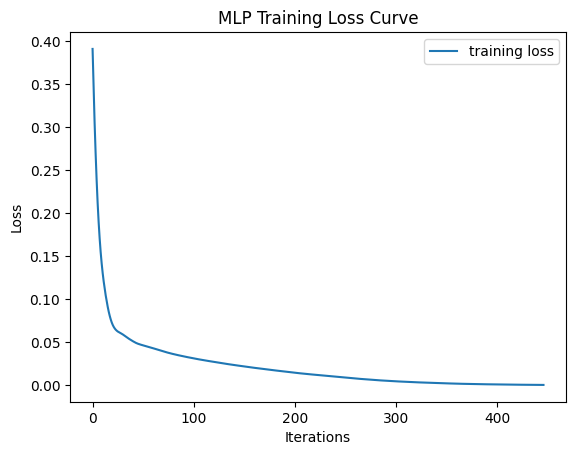

In [6]:
with PowerMonitor(filename = "subset_monthly_MLP_forecasting.csv") as pmon:
    start_time = time.time()
    mlp = MLPRegressor(
        hidden_layer_sizes=(64, 32), 
        activation='relu', 
        solver='adam', 
        max_iter=5000, 
        random_state=42,
        early_stopping=True,
        n_iter_no_change=50,
        verbose=False,
    )

    # sklearn's MLPRegressor.fit does not accept eval_set; early_stopping=True will use an internal validation split
    historymlp = mlp.fit(X_train_scaled, y_train_scaled)

    plt.plot(historymlp.loss_curve_, label='training loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('MLP Training Loss Curve')
    plt.legend()
    execution_times["mlp fit"] = time.time() - start_time
power_stats["mlp fit"] = pmon.stats()

In [7]:
with PowerMonitor(filename = "subset_monthly_MLP_forecasting.csv") as pmon:
    start_time = time.time()
    y_pred_val_scaled = mlp.predict(X_val_scaled)
    # Convert back from scaled units to gCO2/kWh
    y_pred_val = scaler_y.inverse_transform(y_pred_val_scaled.reshape(-1, 1)).flatten()

    y_pred_test_scaled = mlp.predict(X_test_scaled)
    y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()

    # Calculate metrics for validation and test sets
    val_mse = mean_squared_error(y_val, y_pred_val)
    val_mae = mean_absolute_error(y_val, y_pred_val)

    test_mse = mean_squared_error(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    execution_times["mlp prediction"] = time.time() - start_time
power_stats["mlp prediction"] = pmon.stats()

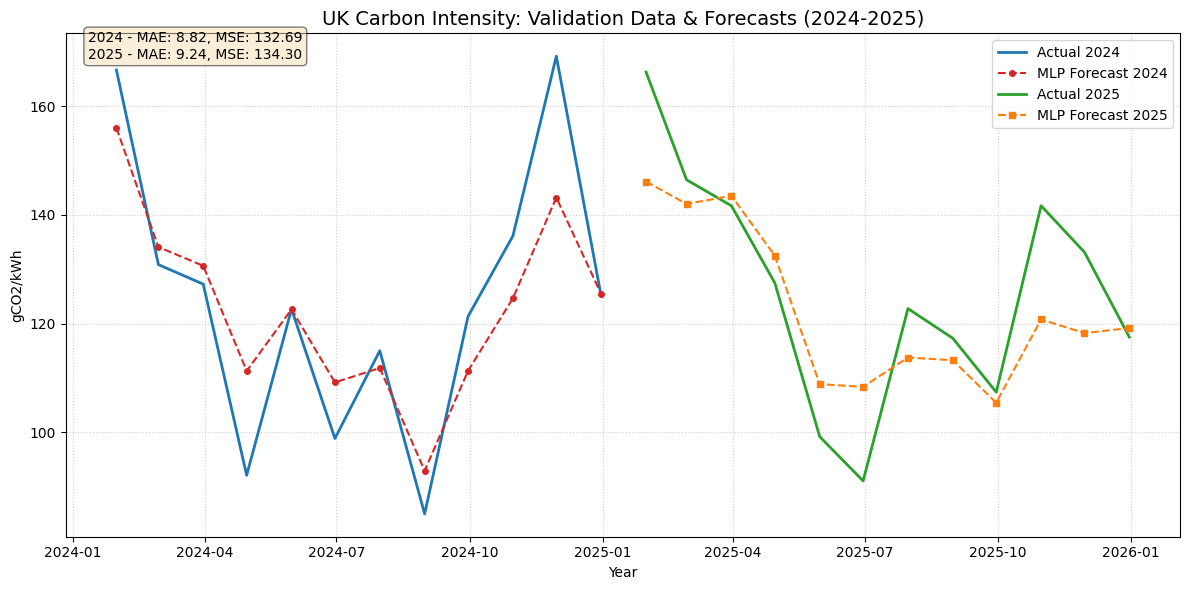

total execution time:  1.3984572887420654
{'df import': 0.8412816524505615, 'create_features': 0.006777048110961914, 'data split': 0.003856182098388672, 'data scaling': 0.00402069091796875, 'mlp fit': 0.3875083923339844, 'mlp prediction': 0.0020570755004882812, 'plot': 0.15295624732971191}


In [8]:
with PowerMonitor(filename = "subset_monthly_MLP_forecasting.csv") as pmon:
    start_time = time.time()
    plt.figure(figsize=(12, 6))

    plt.plot(val['DATETIME'], val['CARBON_INTENSITY'], 
            color='tab:blue', linewidth=2, label='Actual 2024')

    plt.plot(val['DATETIME'], y_pred_val, 
            color='tab:red', linestyle='--', marker='o', markersize=4, label='MLP Forecast 2024')

    plt.plot(test['DATETIME'], test['CARBON_INTENSITY'], 
            color='tab:green', linewidth=2, label='Actual 2025')

    plt.plot(test['DATETIME'], y_pred_test, 
            color='tab:orange', linestyle='--', marker='s', markersize=4, label='MLP Forecast 2025')

    plt.title('UK Carbon Intensity: Validation Data & Forecasts (2024-2025)', fontsize=14)
    plt.xlabel('Year')
    plt.ylabel('gCO2/kWh')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle=':', alpha=0.6)

    # Add metrics text box
    metrics_text = f"2024 - MAE: {val_mae:.2f}, MSE: {val_mse:.2f}\n2025 - MAE: {test_mae:.2f}, MSE: {test_mse:.2f}"
    plt.text(0.02, 0.95, metrics_text, 
            fontsize=10, color='black', transform=plt.gca().transAxes,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()
    execution_times["plot"] = time.time() - start_time
    print("total execution time: ", sum(execution_times.values()))
    print(execution_times)
power_stats["plot"] = pmon.stats()

In [9]:
# Print power usage summary
print("\nPOWER USAGE SUMMARY")
for task, stats in power_stats.items():
    print(f"{task}: {stats}")

# Calculate and print total energy used by the program
print("\n" + "="*50)
print("TOTAL ENERGY USED (Average Power × Runtime)")
print("="*50)

total_energy_joules = 0
for task, stats in power_stats.items():
    if stats and task in execution_times:
        # Sum up average power from all components (CPU Package, CPU Cores, CPU Memory, CPU Platform, GPU Power)
        total_avg_power = 0
        for component, data in stats.items():
            if isinstance(data, dict) and 'avg' in data:
                total_avg_power += data['avg']
        
        runtime = execution_times[task]
        energy = total_avg_power * runtime  # Energy in Joules = Power (Watts) × Time (seconds)
        total_energy_joules += energy
        print(f"{task}: {total_avg_power:.2f}W × {runtime:.4f}s = {energy:.2f}J")

print(f"\nTotal Energy Used: {total_energy_joules:.2f} Joules")
print(f"Total Energy Used: {total_energy_joules/1000:.4f} kJ (kilojoules)")
print("="*50)


POWER USAGE SUMMARY
df import: {'CPU Package': {'min': 14.783504486083984, 'max': 14.783504486083984, 'avg': 14.783504486083984, 'samples': 1}, 'CPU Cores': {'min': 15.812374114990234, 'max': 15.812374114990234, 'avg': 15.812374114990234, 'samples': 1}, 'CPU Memory': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 1}, 'CPU Platform': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 1}, 'GPU Power': {'min': 0.044518694281578064, 'max': 0.044518694281578064, 'avg': 0.044518694281578064, 'samples': 1}}
create_features: None
data split: None
data scaling: None
mlp fit: None
mlp prediction: {'CPU Package': {'min': 9.943076133728027, 'max': 9.943076133728027, 'avg': 9.943076133728027, 'samples': 1}, 'CPU Cores': {'min': 6.270552635192871, 'max': 6.270552635192871, 'avg': 6.270552635192871, 'samples': 1}, 'CPU Memory': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 1}, 'CPU Platform': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 1}, 'GPU Power': {'min': 0.02815956622362137, 'max': 0.02815